In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets
from datetime import datetime, timedelta
import plotly
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import itertools
import json
from fbprophet.serialize import model_to_json

sns.set()

### Binance Data

### Yahoo Finance (Coinmarketcap) Data

In [2]:
start_date = '2016-01-02'
end_date = datetime.today() - timedelta(1)
end_date = datetime.strftime(end_date, '%Y-%m-%d')

In [4]:
yf_data = yf.download('ETH-USD',start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
yf_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2144 entries, 2016-01-01 to 2021-11-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2144 non-null   float64
 1   High       2144 non-null   float64
 2   Low        2144 non-null   float64
 3   Close      2144 non-null   float64
 4   Adj Close  2144 non-null   float64
 5   Volume     2144 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 117.2 KB


In [6]:
yf_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
yf_data = yf_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)

In [8]:
pd.date_range(start = start_date, end = end_date ).difference(yf_data.index)

DatetimeIndex(['2020-04-17', '2020-10-09', '2020-10-12', '2020-10-13',
               '2021-11-18'],
              dtype='datetime64[ns]', freq=None)

In [9]:
new_date_range = pd.date_range(start = start_date, end = end_date, freq="D")
yf_data = yf_data.reindex(new_date_range, method = 'ffill')

In [10]:
pd.date_range(start = start_date, end = end_date ).difference(yf_data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [11]:
yf_data.tail(10)

Close
2021-11-09  4735.068848
2021-11-10  4636.174316
2021-11-11  4730.384277
2021-11-12  4667.115234
2021-11-13  4651.460449
2021-11-14  4626.358887
2021-11-15  4557.503906
2021-11-16  4216.365234
2021-11-17  4287.593750
2021-11-18  4287.593750

In [12]:
prophet_df = yf_data.reset_index(level = 0)

In [13]:
prophet_df = prophet_df.rename({'index': 'ds', 'Close': 'y'}, axis = 1)
prophet_df

ds            y
0    2016-01-02     0.937124
1    2016-01-03     0.971905
2    2016-01-04     0.954480
3    2016-01-05     0.950176
4    2016-01-06     0.950860
...         ...          ...
2143 2021-11-14  4626.358887
2144 2021-11-15  4557.503906
2145 2021-11-16  4216.365234
2146 2021-11-17  4287.593750
2147 2021-11-18  4287.593750

[2148 rows x 2 columns]

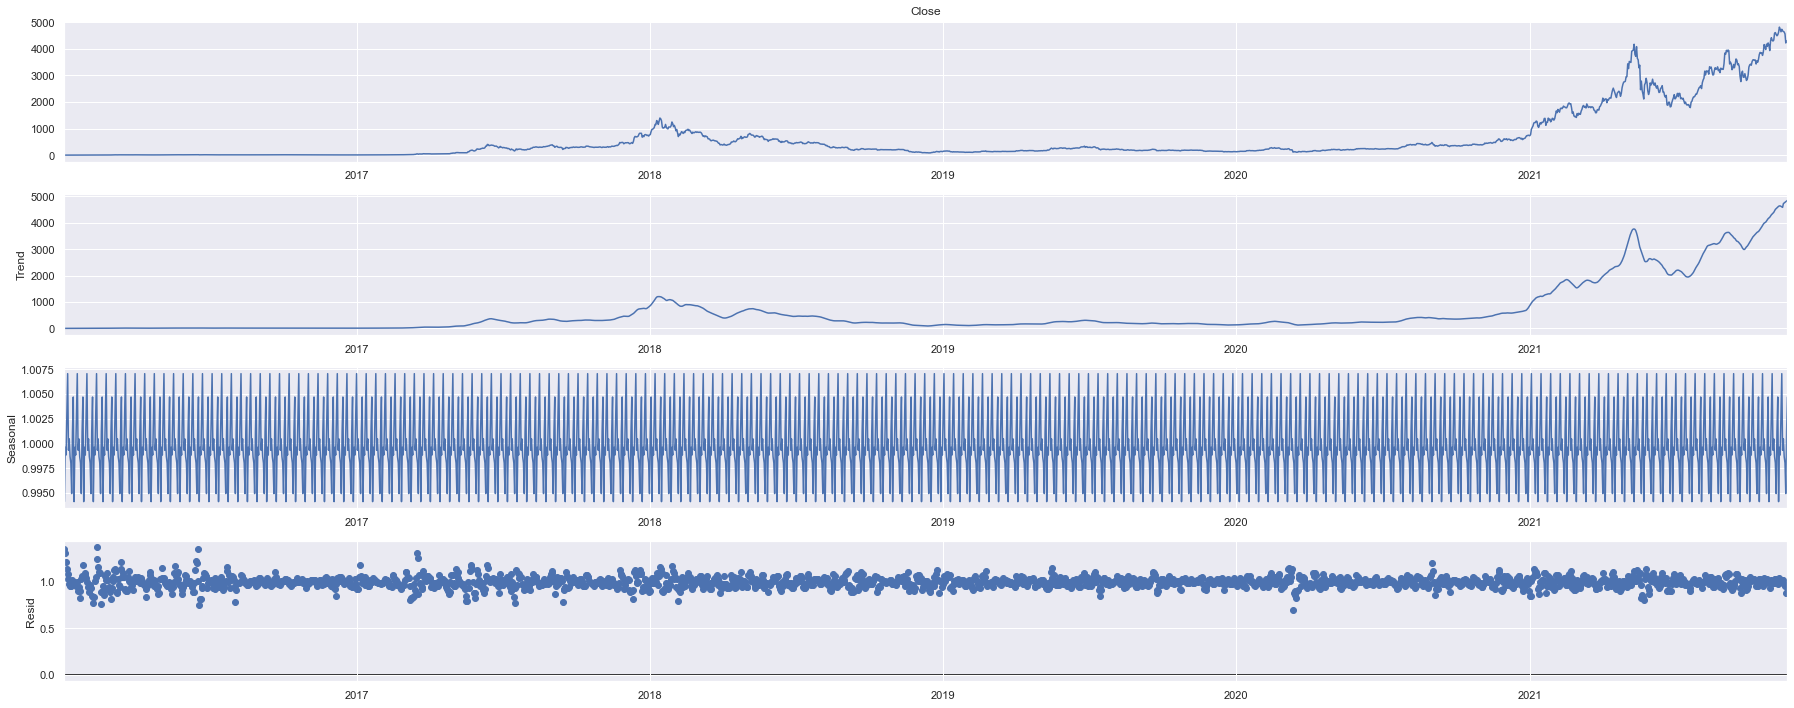

In [19]:
decomp = seasonal_decompose(yf_data['Close'], model = 'multiplicative', extrapolate_trend = 'freq', period = 12)
plt.rcParams.update({'figure.figsize': (25,10)})
decomp.plot()
plt.show()

In [20]:
model = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    interval_width = 0.95
)
model.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
future = model.make_future_dataframe(periods = 60)

In [24]:
forecast = model.predict(future)
forecast_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast_data

ds         yhat   yhat_lower   yhat_upper
2203 2022-01-13  4846.302201  4590.376063  5107.860687
2204 2022-01-14  4846.825957  4589.533784  5093.950670
2205 2022-01-15  4863.642070  4598.502851  5113.904223
2206 2022-01-16  4877.918685  4623.454766  5123.762519
2207 2022-01-17  4876.069933  4626.109093  5133.356225

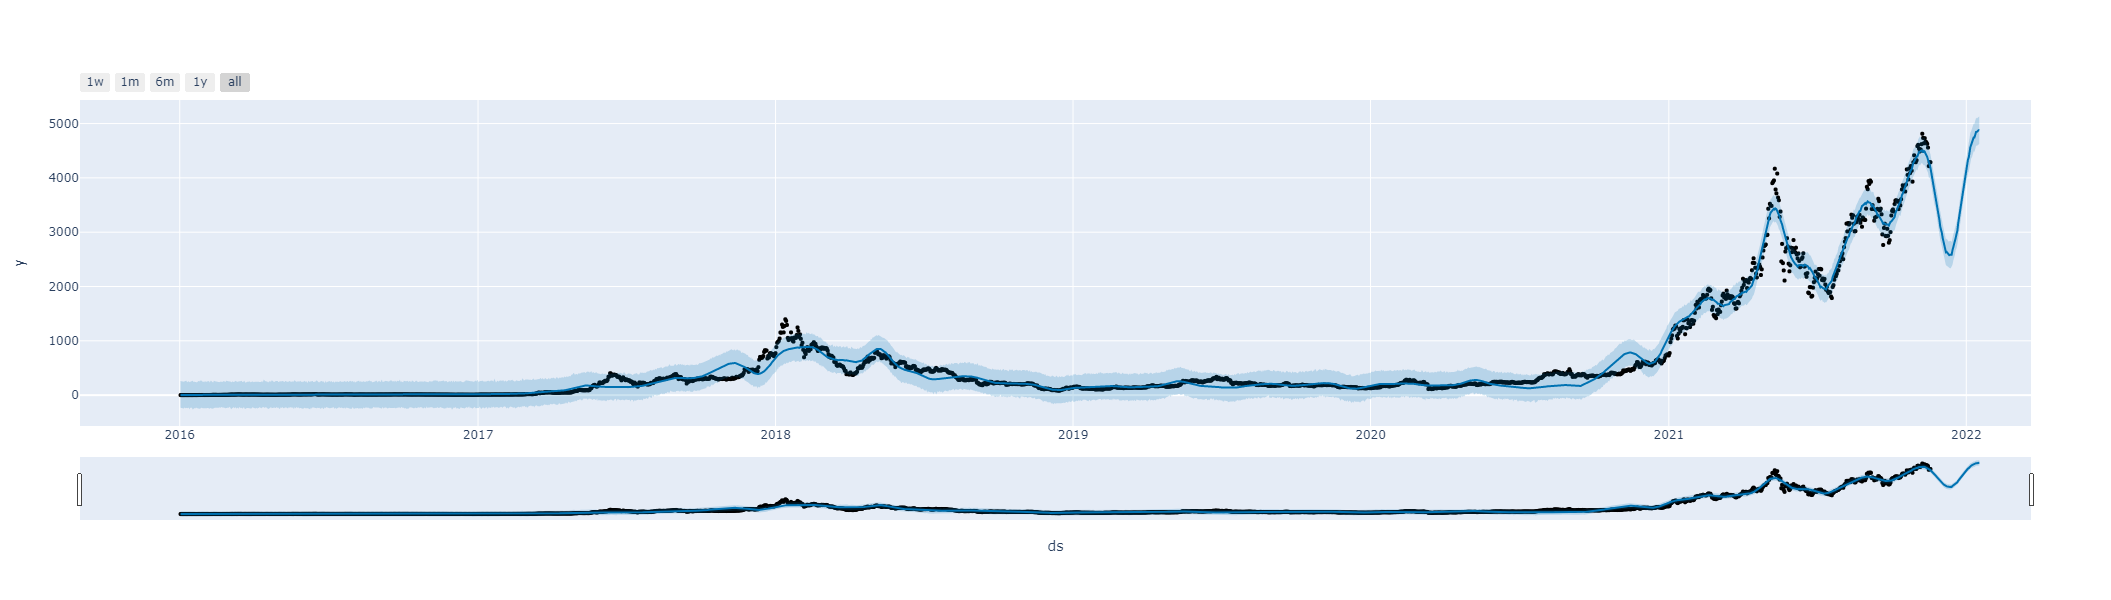

In [26]:
plot_plotly(model, forecast)

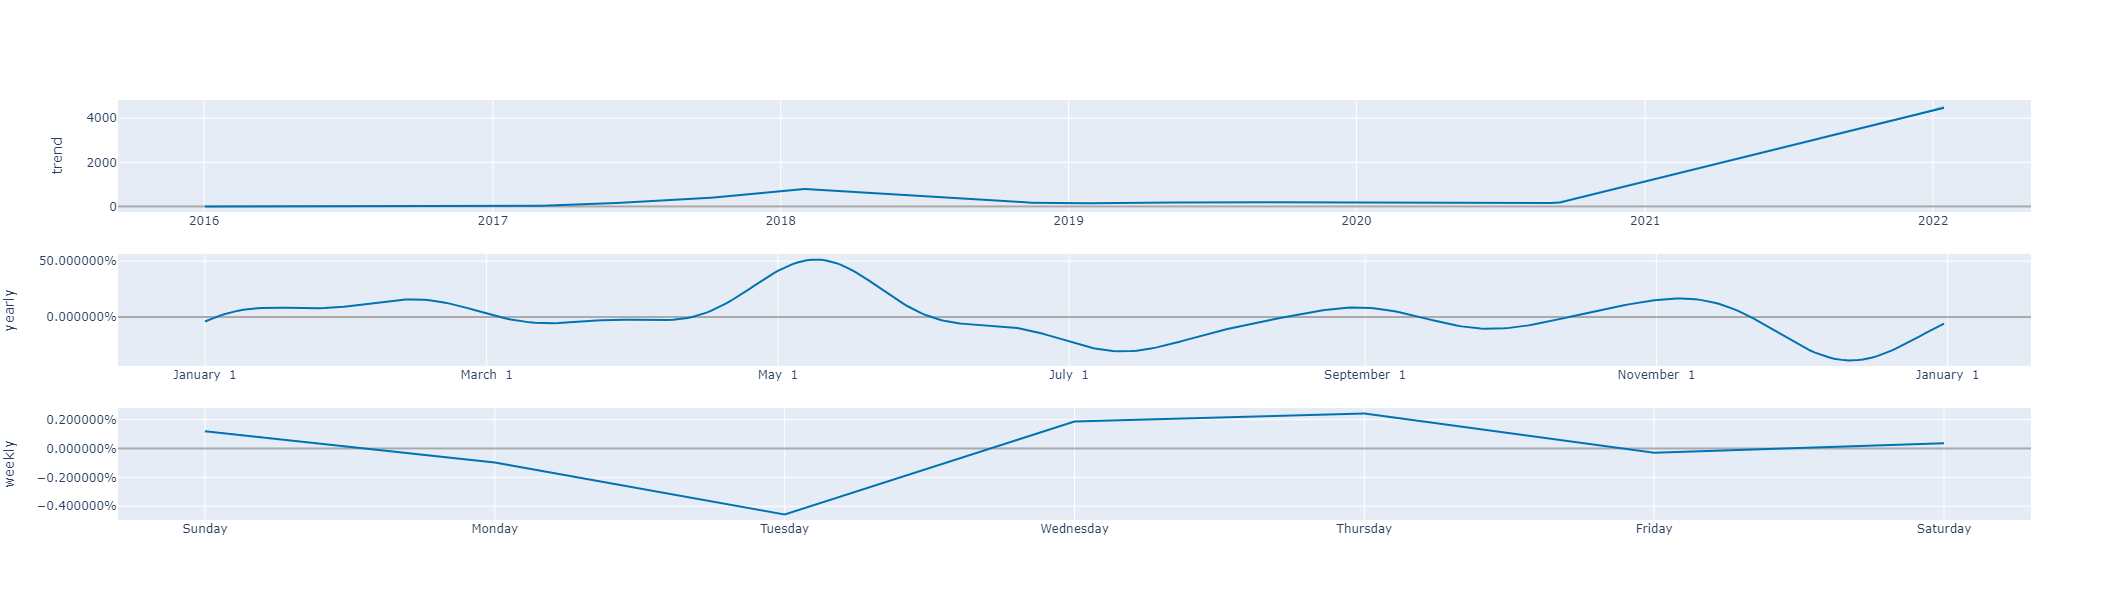

In [31]:
plot_components_plotly(model, forecast)

In [32]:
df_cv = cross_validation(model, initial='730 days', period='30 days', horizon = '60 days')

INFO:fbprophet:Making 46 forecasts with cutoffs between 2018-01-06 00:00:00 and 2021-09-17 00:00:00


  0%|          | 0/46 [00:00<?, ?it/s]

In [33]:
df_cv.head(10)

ds         yhat   yhat_lower   yhat_upper            y     cutoff
0 2018-01-07  1125.798251  1092.459287  1162.391088  1153.170044 2018-01-06
1 2018-01-08  1234.441297  1198.507846  1267.442457  1148.530029 2018-01-06
2 2018-01-09  1358.558233  1321.620701  1394.465648  1299.739990 2018-01-06
3 2018-01-10  1478.628014  1443.189542  1513.079935  1255.819946 2018-01-06
4 2018-01-11  1606.373279  1573.817561  1639.783818  1154.930054 2018-01-06
5 2018-01-12  1749.475325  1714.712257  1781.604696  1273.199951 2018-01-06
6 2018-01-13  1913.716397  1877.329545  1949.469857  1396.420044 2018-01-06
7 2018-01-14  2089.998986  2057.238889  2125.544617  1366.770020 2018-01-06
8 2018-01-15  2299.110823  2265.830366  2332.094207  1291.920044 2018-01-06
9 2018-01-16  2521.661409  2482.871737  2560.608203  1053.689941 2018-01-06

In [34]:
df_p = performance_metrics(df_cv)

In [35]:
df_p

horizon            mse        rmse         mae      mape     mdape  \
0   6 days   28043.060140  167.460623  116.624487  0.291301  0.215825   
1   7 days   31339.508892  177.029684  125.518944  0.307679  0.229135   
2   8 days   35434.985945  188.241828  133.687641  0.324560  0.230975   
3   9 days   44700.600835  211.425166  147.414376  0.343138  0.242449   
4  10 days   61742.271393  248.479922  164.937114  0.363311  0.252047   
5  11 days   83696.411212  289.303320  184.966687  0.383403  0.263136   
6  12 days  110092.940847  331.802563  204.198040  0.402254  0.275110   
7  13 days  147105.859370  383.543817  227.456048  0.420844  0.285215   
8  14 days  194601.064152  441.136106  254.888766  0.438652  0.298242   
9  15 days  247468.618399  497.462178  281.205459  0.455287  0.314087   
10 16 days  307166.118996  554.225693  307.639364  0.470413  0.328299   
11 17 days  368615.522501  607.137153  332.621673  0.486491  0.348623   
12 18 days  439101.155977  662.647083  359.277729  0.501331  0.369936   
13 19 days  508159.910879  712.853359  382.725439  0.517244  0.388334   
14 20 days  565381.445274  751.918510  401.037673  0.534053  0.396539   
15 21 days  622260.241354  788.834736  417.987256  0.549024  0.409985   
16 22 days  663376.622966  814.479357  431.135890  0.563498  0.440817   
17 23 days  699538.243031  836.384028  440.313656  0.575414  0.463414   
18 24 days  736672.972924  858.296553  447.234648  0.589179  0.471456   
19 25 days  765681.476115  875.032271  453.318335  0.602081  0.475909   
20 26 days  796167.581363  892.282232  458.135211  0.611961  0.479468   
21 27 days  822292.415154  906.803405  460.545494  0.624540  0.489430   
22 28 days  853040.710480  923.602030  463.543971  0.635960  0.493598   
23 29 days  874940.492594  935.382538  463.147170  0.648885  0.495327   
24 30 days  885246.032332  940.875142  460.797807  0.663445  0.493598   
25 31 days  885632.114622  941.080291  454.425585  0.671406  0.494747   
26 32 days  883499.425382  939.946501  450.433495  0.681837  0.494747   
27 33 days  865113.905305  930.114996  443.466132  0.687138  0.487364   
28 34 days  834146.599415  913.316265  434.720898  0.691158  0.471846   
29 35 days  808317.401032  899.064737  431.737022  0.694660  0.467576   
30 36 days  778092.708960  882.095635  429.016443  0.694550  0.462436   
31 37 days  744951.099246  863.105497  426.698600  0.696860  0.456523   
32 38 days  707508.277981  841.135113  421.583287  0.698283  0.437544   
33 39 days  673629.169935  820.749152  419.002516  0.699408  0.430325   
34 40 days  641140.184050  800.712298  416.593081  0.698029  0.428198   
35 41 days  611939.360601  782.265531  414.415673  0.693135  0.426547   
36 42 days  581855.456184  762.794505  412.040686  0.687255  0.428198   
37 43 days  567022.685623  753.009087  414.672973  0.683810  0.433024   
38 44 days  562374.880942  749.916583  421.429440  0.678247  0.443723   
39 45 days  566768.985335  752.840611  429.443153  0.672333  0.449833   
40 46 days  589771.591616  767.965879  440.682760  0.667807  0.461797   
41 47 days  609126.823245  780.465773  451.009540  0.666486  0.465846   
42 48 days  638054.626743  798.783216  462.787297  0.660875  0.474497   
43 49 days  664989.537308  815.468906  472.483912  0.657785  0.483196   
44 50 days  680559.759586  824.960459  478.204369  0.656475  0.486186   
45 51 days  702245.526679  838.000911  484.004333  0.656520  0.490419   
46 52 days  713376.705777  844.616307  487.234230  0.659190  0.493993   
47 53 days  720906.499468  849.062129  488.535119  0.661025  0.502051   
48 54 days  727254.600814  852.792238  489.432677  0.668269  0.505184   
49 55 days  733581.319964  856.493619  491.751722  0.675013  0.514973   
50 56 days  742880.790305  861.905326  494.505217  0.678229  0.520543   
51 57 days  742852.269018  861.888780  496.200562  0.684579  0.529469   
52 58 days  747810.129071  864.760157  499.219458  0.691584  0.532514   
53 59 days  741639.678597  861.185043  498.635069  0.696355  

C:\Users\liamt\anaconda3\envs\sktime\lib\site-packages\fbprophet\plot.py:526: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

C:\Users\liamt\anaconda3\envs\sktime\lib\site-packages\fbprophet\plot.py:527: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



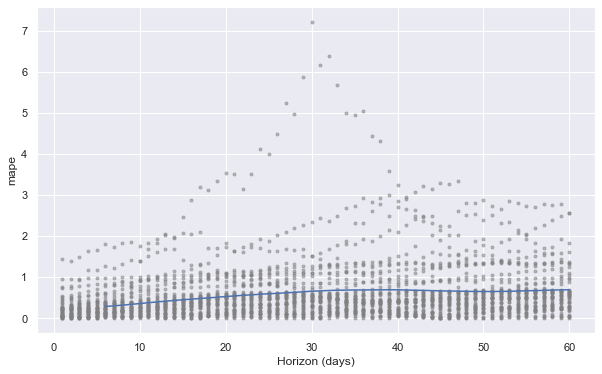

In [36]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [38]:
cutoffs = pd.to_datetime(['2018-01-01', '2018-04-01', '2019-01-01', '2020-01-01'])
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mae = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, seasonality_mode="multiplicative").fit(prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon = '60 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mae.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = mae
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002836756F580>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000283666503A0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000028369702880>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000028366661190>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet

    changepoint_prior_scale  seasonality_prior_scale          mae
0                     0.001                     0.01   306.520233
1                     0.001                     0.10   527.998294
2                     0.001                     1.00   386.702441
3                     0.001                    10.00   510.754492
4                     0.010                     0.01   235.495230
5                     0.010                     0.10   290.735959
6                     0.010                     1.00   311.312059
7                     0.010                    10.00   310.142478
8                     0.100                     0.01   285.031374
9                     0.100                     0.10   187.416424
10                    0.100                     1.00   256.649995
11                    0.100                    10.00   257.321873
12                    0.500                     0.01   301.374620
13                    0.500                     0.10   167.961417
14        

In [39]:
tuning_results.sort_values(['mae'])

changepoint_prior_scale  seasonality_prior_scale          mae
13                    0.500                     0.10   167.961417
9                     0.100                     0.10   187.416424
4                     0.010                     0.01   235.495230
10                    0.100                     1.00   256.649995
11                    0.100                    10.00   257.321873
8                     0.100                     0.01   285.031374
5                     0.010                     0.10   290.735959
12                    0.500                     0.01   301.374620
0                     0.001                     0.01   306.520233
7                     0.010                    10.00   310.142478
6                     0.010                     1.00   311.312059
2                     0.001                     1.00   386.702441
3                     0.001                    10.00   510.754492
1                     0.001                     0.10   527.998294
14                    0.500                     1.00  1834.981050
15                    0.500                    10.00  2120.203841

In [40]:
tuned_prophet = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    interval_width = 0.95,
    changepoint_prior_scale = 0.5,
    seasonality_prior_scale = 0.1
    
    
)
tuned_prophet.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
tuned_future = tuned_prophet.make_future_dataframe(periods = 60)

In [42]:
tuned_forecast = tuned_prophet.predict(future)
tuned_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
2201 2022-01-11  4617.657478  4210.934712  5034.332715
2202 2022-01-12  4666.681569  4219.805634  5041.665931
2203 2022-01-13  4676.045325  4226.655216  5043.476138
2204 2022-01-14  4665.442269  4202.612922  5056.166994
2205 2022-01-15  4667.013620  4231.853908  5045.979904

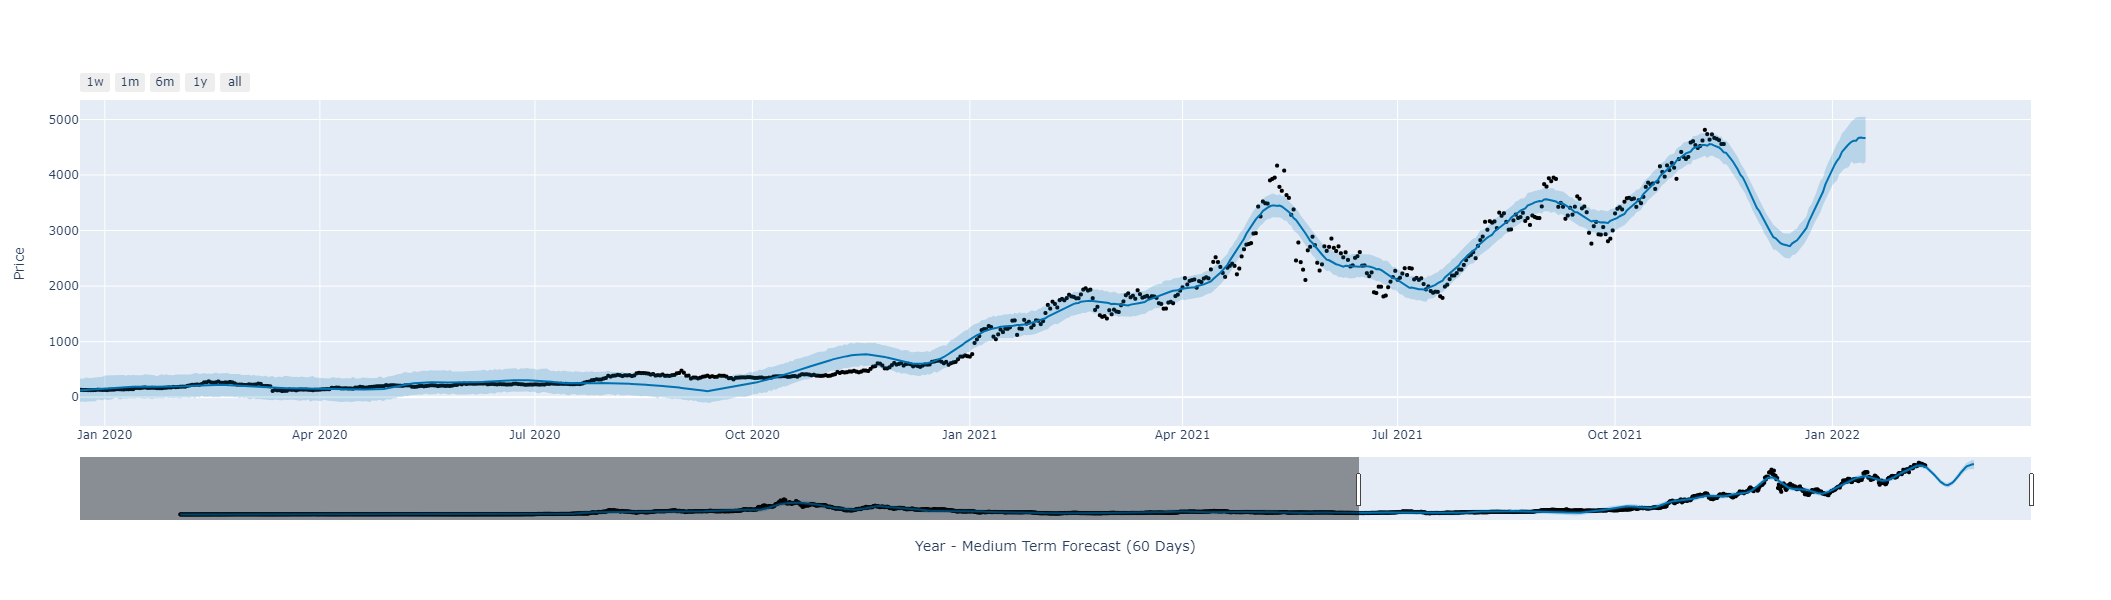

In [43]:
long_plot = plot_plotly(tuned_prophet, tuned_forecast,
                       xlabel = 'Year - Medium Term Forecast (60 Days) ',
                       ylabel = 'Price')
long_plot

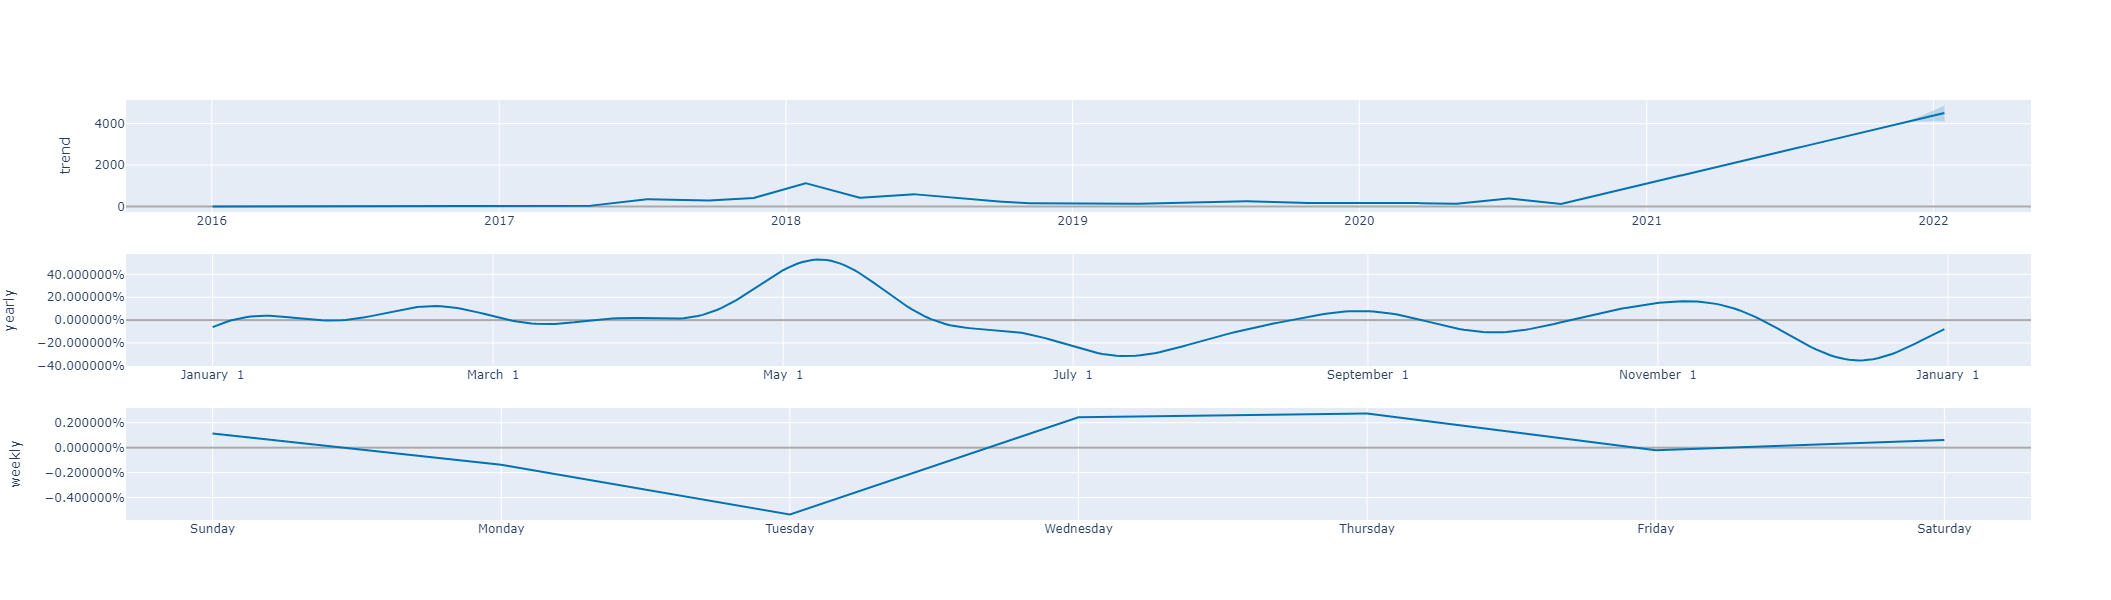

In [44]:
components_plot = plot_components_plotly(tuned_prophet, tuned_forecast)
components_plot

In [45]:
tuned_df_cv = cross_validation(tuned_prophet, initial='730 days', period='30 days', horizon = '60 days')

INFO:fbprophet:Making 46 forecasts with cutoffs between 2018-01-06 00:00:00 and 2021-09-17 00:00:00


  0%|          | 0/46 [00:00<?, ?it/s]

In [46]:
tuned_df_p = performance_metrics(tuned_df_cv)

In [47]:
tuned_df_p

horizon           mse         rmse         mae      mape     mdape  \
0   6 days  2.362805e+04   153.714178   90.828453  0.182369  0.134861   
1   7 days  2.697588e+04   164.243370   99.789287  0.195979  0.148889   
2   8 days  3.171526e+04   178.087778  108.440875  0.210007  0.158959   
3   9 days  4.211635e+04   205.222689  122.106475  0.226658  0.170587   
4  10 days  6.178261e+04   248.561077  136.883036  0.244688  0.185131   
5  11 days  8.848405e+04   297.462690  156.303507  0.266598  0.194705   
6  12 days  1.213909e+05   348.411971  175.094266  0.285795  0.206101   
7  13 days  1.665750e+05   408.136022  199.164475  0.306454  0.226982   
8  14 days  2.236072e+05   472.871208  227.696443  0.327792  0.244278   
9  15 days  2.887068e+05   537.314443  255.116394  0.349022  0.259165   
10 16 days  3.634411e+05   602.860803  284.782975  0.372379  0.278543   
11 17 days  4.430763e+05   665.639742  312.442549  0.394176  0.288227   
12 18 days  5.333831e+05   730.330816  342.736944  0.416065  0.313590   
13 19 days  6.255645e+05   790.926380  368.982668  0.436707  0.329436   
14 20 days  7.092351e+05   842.160984  389.873393  0.458428  0.336228   
15 21 days  7.928335e+05   890.411992  408.624739  0.474904  0.343087   
16 22 days  8.601242e+05   927.428791  422.342808  0.487023  0.343087   
17 23 days  9.239014e+05   961.197915  432.690026  0.496263  0.346353   
18 24 days  9.909583e+05   995.468875  441.930875  0.509768  0.346927   
19 25 days  1.048458e+06  1023.942496  450.228618  0.522907  0.358306   
20 26 days  1.106215e+06  1051.767587  457.386177  0.533138  0.348520   
21 27 days  1.159054e+06  1076.593894  462.973955  0.548237  0.353866   
22 28 days  1.212741e+06  1101.245065  469.693977  0.562328  0.357515   
23 29 days  1.254330e+06  1119.968803  472.495125  0.580937  0.357515   
24 30 days  1.280189e+06  1131.454275  472.054897  0.600571  0.355919   
25 31 days  1.289991e+06  1135.777820  467.647139  0.613076  0.353448   
26 32 days  1.291061e+06  1136.248835  464.813576  0.626217  0.352630   
27 33 days  1.268445e+06  1126.252464  459.017106  0.632801  0.352630   
28 34 days  1.227666e+06  1108.000846  450.811171  0.636613  0.352630   
29 35 days  1.184358e+06  1088.282033  447.458803  0.636591  0.357254   
30 36 days  1.130786e+06  1063.384290  445.119519  0.632722  0.370378   
31 37 days  1.072244e+06  1035.492346  443.579019  0.632724  0.375853   
32 38 days  1.007728e+06  1003.856568  439.210742  0.632118  0.392479   
33 39 days  9.454942e+05   972.365237  436.958628  0.631378  0.401511   
34 40 days  8.860078e+05   941.279888  435.815203  0.632788  0.408526   
35 41 days  8.304607e+05   911.296163  435.793574  0.633595  0.411370   
36 42 days  7.748632e+05   880.263159  434.613509  0.632120  0.411370   
37 43 days  7.370477e+05   858.514830  437.793681  0.631292  0.419559   
38 44 days  7.108760e+05   843.134630  445.554005  0.630169  0.426791   
39 45 days  6.978859e+05   835.395638  455.168676  0.632011  0.424144   
40 46 days  7.063206e+05   840.428794  467.664377  0.633433  0.424144   
41 47 days  7.142219e+05   845.116489  478.916934  0.637115  0.457726   
42 48 days  7.341816e+05   856.843957  491.492104  0.635668  0.471276   
43 49 days  7.542978e+05   868.503178  502.627520  0.637455  0.477864   
44 50 days  7.652063e+05   874.760710  509.323135  0.639296  0.484627   
45 51 days  7.829451e+05   884.841853  515.892404  0.639817  0.484213   
46 52 days  7.909887e+05   889.375455  520.141388  0.642902  0.489586   
47 53 days  7.975015e+05   893.029397  522.808389  0.643968  0.495082   
48 54 days  8.052843e+05   897.376333  525.968885  0.650682  0.502910   
49 55 days  8.137298e+05   902.069719  530.118352  0.657649  0.538919   
50 56 days  8.270863e+05   909.442876  535.427300  0.663624  0.540094   
51 57 days  8.328023e+05   912.580032  538.840345  0.670827  0.546729   
52 58 days  8.476660e+05   920.687798  543.981690  0.678182  0.552126   
53 59 days  8.548982e+05   924.607068  546.704899  0.686488  

In [48]:
short_term = tuned_prophet.make_future_dataframe(periods = 10)

In [49]:
short_term_forecast = tuned_prophet.predict(short_term)
short_term_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
2151 2021-11-22  4093.420117  3891.006230  4309.913906
2152 2021-11-23  4003.682858  3784.565652  4214.895470
2153 2021-11-24  3957.173683  3751.307658  4158.519110
2154 2021-11-25  3876.783736  3672.347340  4083.847026
2155 2021-11-26  3780.313298  3565.863872  4001.257668

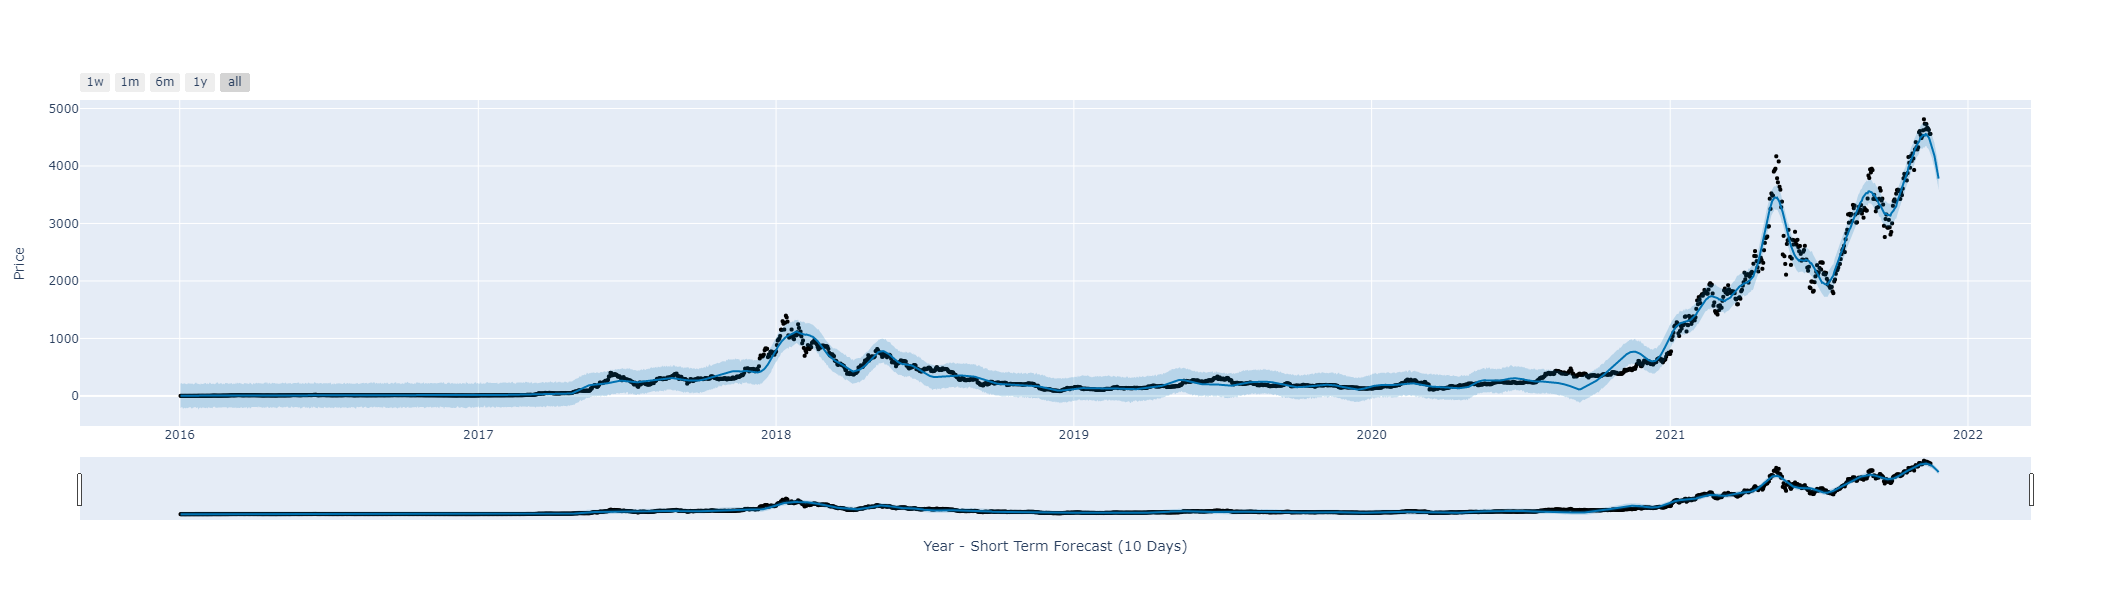

In [57]:
short_plot = plot_plotly(tuned_prophet, short_term_forecast,
                        xlabel = 'Year - Short Term Forecast (10 Days)',
                        ylabel = 'Price',
                        )
short_plot

In [69]:
forecast_outlook = tuned_df_p[['horizon', 'mae', 'mape']][:9]

In [70]:
forecast_outlook = forecast_outlook.rename({'mae': '+/- Dollars (USD)', 'horizon': 'Horizon'}, axis = 1)

In [71]:
forecast_outlook['Accuracy (%)'] = forecast_outlook.apply(lambda row: 100 - row['mape']*100, axis = 1)

In [72]:
forecast_outlook = forecast_outlook.drop('mape', axis = 1)

In [73]:
forecast_outlook.round(2)

Horizon  +/- Dollhairs (USD)  % Accuracy
0  6 days                90.83       81.76
1  7 days                99.79       80.40
2  8 days               108.44       79.00
3  9 days               122.11       77.33
4 10 days               136.88       75.53
5 11 days               156.30       73.34
6 12 days               175.09       71.42
7 13 days               199.16       69.35
8 14 days               227.70       67.22

In [74]:
with open('ETH_Prophet.html', 'a') as f:
    f.write(long_plot.to_html(full_html=False, include_plotlyjs='cdn')),
    f.write(short_plot.to_html(full_html=False, include_plotlyjs='cdn')),
    f.write(components_plot.to_html(full_html=False, include_plotlyjs='cdn'))  

In [76]:
with open('Pro_ETH_model.json', 'w') as f:
    json.dump(model_to_json(tuned_prophet), f)